In [1]:
#入力部
#グラフのデータタイトル
tittle="0deg"
#読み込みファイル名(txtファイル対応)
filename="0deg.txt"
#kerrの調整(元データがKerrの場合はA～Dの変数を1にE,Fを100に設定)
#Kerr=[(A/B)*(C/D)*data]/[(E-F)/2]*100[%]
#A=オシロの標準資料磁化印加時最大最小電圧差
A=6*10**(-3)
#B=標準資料のロックインアンプ電圧値[V]
B=65*10**(-6)
#C=サンプルLIA電圧値[V]
C=-25.5*10**(-6)
#D=サンプルオシロ電圧値[V]
D=-2.6
#E=サンプル磁場印加時の正電圧値[V]
E=150*10**(-3)
#F=サンプル磁場印加時の負電圧値[V]
F=-169*10**(-3)
#入力ここまで
import numpy as np
data=open(filename,'r').read()
data=np.array(data.split('\n'))
k=data.shape[0]
for i in range(1, k):
    data1=np.array(data[i-1].split())
    if i==1:
        data2=data1
        list=[[int(i-1)]]
    else:
        if data2.ndim==1:
            dt12=np.array([float(format(float(data1[0])-float(data2[0]),'.1E'))])
            dt=dt12[0]
        else:
            dt=float(format(float(data1[0])-float(data2[data2.shape[0]-1,0]),'.1E'))
        data2=np.vstack([data2,data1])
        if 0.98*dt12[np.array(dt12).shape[0]-1]<dt<1.02*dt12[np.array(dt12).shape[0]-1]:
                list[np.array(dt12).shape[0]-1].append(int(i-1))
        else:
                    dt12=np.append(dt12,[dt])
                    list.insert(2, [int(i-1)])
list=np.array(list, dtype=object)
data2=data2.astype(float)
x=data2[:,0]
y=A/B*C/D/((E-F)/2)*data2[:,1]*100
xFFT=np.array(x[list[list.shape[0]-1]])[y[list[list.shape[0]-1]]!=0]
yFFT=np.array(y[list[list.shape[0]-1]])[y[list[list.shape[0]-1]]!=0]
x=x[y!=0]
y=y[y!=0]
print("amp:"+str(A/B*C/D/((E-F)/2)*100))
print("データの時間差(ps)")
print(dt12)

amp:0.5676021591140955
データの時間差(ps)
[13.    0.67  2.7 ]


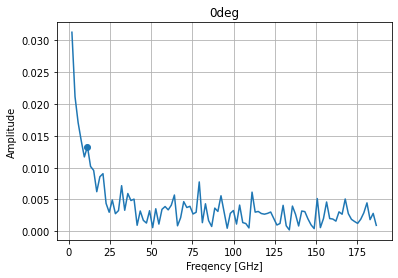

In [2]:
from scipy import signal,interpolate
#フーリエ変換
import matplotlib.pyplot as plt
dt=(xFFT[xFFT.shape[0]-1]-xFFT[0])/xFFT.shape[0]
y_fft = np.fft.fft(yFFT)
freq = np.fft.fftfreq(yFFT.shape[0], d=dt)
Amp = np.abs(y_fft/(yFFT.shape[0]/2))
peaks_freq,_ = signal.find_peaks(Amp[0:int(yFFT.shape[0]/2)])
top_freq=peaks_freq[np.argmax(Amp[peaks_freq])]
fig4, ax4 = plt.subplots()
ax4.plot(10**3*freq[1:int(yFFT.shape[0]/2)], Amp[1:int(yFFT.shape[0]/2)])
ax4.scatter(10**3*freq[top_freq],Amp[top_freq])
ax4.set_xlabel("Freqency [GHz]")
ax4.set_ylabel("Amplitude")
ax4.set_title(tittle)
ax4.grid()
plt.show()
#抽出された歳差運動周波数がおかしかったらイコールの右側の値で調整してください。[THz]
exp_freq=freq[top_freq]

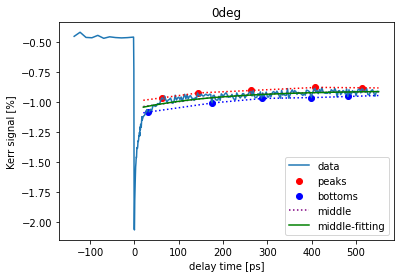

In [3]:
from scipy.optimize import leastsq
peaks,_ = signal.find_peaks(yFFT,distance=int(0.9/exp_freq/dt12[dt12.shape[0]-1]))
bottoms,_=signal.find_peaks(-yFFT,distance=int(0.9/exp_freq/dt12[dt12.shape[0]-1]))
#入力ここから
#参考データ
#fitting参考最大値です。指定したい最大ピーク(peaks[n番目-1])若しくは最小ピーク(bottoms[n番目-1])を"="の隣に入れてください。
end=x.shape[0]-1
#入力ここまで
peaks=peaks[peaks<=end]
bottoms=bottoms[bottoms<=end]
x1=xFFT[:end+1]
y1=yFFT[:end+1]
#最大最小の補間及び中間値
#線形補間
peaksfunc=interpolate.interp1d(xFFT[peaks],yFFT[peaks],kind='linear',fill_value='extrapolate')
bottomsfunc=interpolate.interp1d(x1[bottoms],y1[bottoms],kind='linear',fill_value='extrapolate')
#中間値
k=int(x1.shape[0])
middle_y1=[]
for i in range(k):
    middle_y1.append(float((peaksfunc(x1[i])+bottomsfunc(x1[i]))/2))
#中間値fitting用残差関数
def fit_exp1(parameter, x, y):
    residual = y - (parameter[0] * np.exp(parameter[1] * x) + parameter[2])
    return residual
b_est=middle_y1[np.array(middle_y1).shape[0]-1]
A_est=(peaksfunc(0)+bottomsfunc(0))/2-b_est
k_est=-abs(np.log(abs((middle_y1[0]-b_est)/A_est))/x1[0])
parameter0 = [ A_est,k_est,middle_y1[np.array(middle_y1).shape[0]-1]]#fitting初期値
fitting_func = leastsq(fit_exp1, parameter0, args=(x1 , middle_y1))[0]#fittingパラメータ
middle_func = lambda A, k, x, b: A * np.exp(k * x) + b#プロット用 式
fig,ax = plt.subplots()
ax.plot(x, y, label="data")
ax.scatter(xFFT[peaks],yFFT[peaks], color='red', label="peaks")
ax.scatter(xFFT[bottoms],yFFT[bottoms], color='blue', label="bottoms")
ax.plot(x1,peaksfunc(x1), color='red', linestyle=":")
ax.plot(x1,bottomsfunc(x1),color='blue', linestyle=":")
ax.plot(x1, middle_y1, color="purple",label="middle", linestyle=":")
ax.plot(x1,middle_func(fitting_func[0],fitting_func[1],x1,fitting_func[2]), color='green',label="middle-fitting")
ax.legend()
ax.set_ylabel("Kerr signal [%]")
ax.set_xlabel("delay time [ps]")
ax.set_title(tittle)
plt.show()

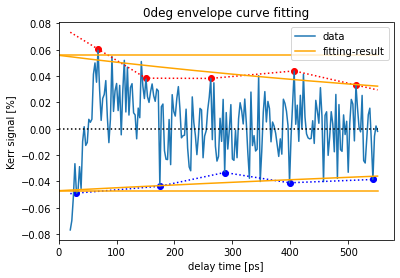

fitting-result [A: 0.05141307819638198,1/τ:-0.0007386021391817926[1/ps],Data = 0.0514*e^(-0.0007*x)]


In [4]:
from numpy import log as ln
def exp_string(A, k):
    return "Data = %0.4f*e^(%0.4f*x)" % (A, k)
y12=[]
k=int(x1.shape[0])
for i in range(k):
    y12.append(float(y1[i]-middle_func(fitting_func[0],fitting_func[1],x1[i],fitting_func[2])))
y12=np.array(y12)
#peak and bottom
peaks1,_ = signal.find_peaks(y12,distance=int(0.9/exp_freq/dt12[dt12.shape[0]-1]),height=np.max(abs(y12))/100)
bottoms1,_=signal.find_peaks(-y12,distance=int(0.9/exp_freq/dt12[dt12.shape[0]-1]),height=np.max(abs(y12))/100)
#fitting用残差関数
def fit_exp(parameter, x, y):
    residual = y - (parameter[0] * np.exp(parameter[1] * x))
    return residual
def model_func(parameter,x):
    return parameter[0] * np.exp(parameter[1] * x)
peaks_func=interpolate.interp1d(x1[peaks1],y12[peaks1],kind='linear',fill_value='extrapolate')
bottoms_func=interpolate.interp1d(x1[bottoms1],y12[bottoms1],kind='linear',fill_value='extrapolate')
#近似初期パラメータ
max_parameter0 = [ peaks_func(0), np.average(ln(y12[peaks1]/peaks_func(0))/x1[peaks1])]
min_parameter0 = [ bottoms_func(0), np.average(ln(abs(y12[bottoms1]/bottoms_func(0)))/x1[bottoms1])]
#fittingパラメータ
Nonlinear_peaks = leastsq(fit_exp, max_parameter0, args=(x1[peaks1], y12[peaks1]))[0]
Nonlinear_bottoms = leastsq(fit_exp, min_parameter0, args=(x1[bottoms1], y12[bottoms1]))[0]
xfunc=np.linspace(0,x1[x1.shape[0]-1],1000)
#グラフ
fig3,ax3 = plt.subplots()
ax3.plot(x1, y12, label="data")
ax3.plot(x1,peaks_func(x1), color='red', linestyle=":")
ax3.plot(x1,bottoms_func(x1), color='blue', linestyle=":")
ax3.plot(xfunc, model_func(Nonlinear_peaks, xfunc),color="orange",label="fitting-result")
ax3.plot(xfunc, model_func(Nonlinear_bottoms, xfunc),color="orange")
ax3.plot([0,x1[x1.shape[0]-1]],[0,0],color="black", linestyle=":")
ax3.scatter(x1[peaks1],y12[peaks1], color='red')
ax3.scatter(x1[bottoms1],y12[bottoms1], color='blue')
ax3.legend(loc = 'upper right')
ax3.set_xlim(0)
ax3.plot([0,x1[x1.shape[0]-1]],[model_func(Nonlinear_peaks, 0),model_func(Nonlinear_peaks, 0)],color="orange")
ax3.plot([0,x1[x1.shape[0]-1]],[model_func(Nonlinear_bottoms,0),model_func(Nonlinear_bottoms,0)],color="orange")
ax3.set_xlabel("delay time [ps]")
ax3.set_ylabel("Kerr signal [%]")
ax3.set_title(tittle+" envelope curve fitting")
plt.show()
exp_A=(abs(Nonlinear_peaks[0])+abs(Nonlinear_bottoms[0]))/2
exp_t=(Nonlinear_peaks[1]+Nonlinear_bottoms[1])/2
print("fitting-result [A: "+str(exp_A)+",1/τ:"+str(exp_t)+"[1/ps],"+exp_string(exp_A, exp_t)+"]")

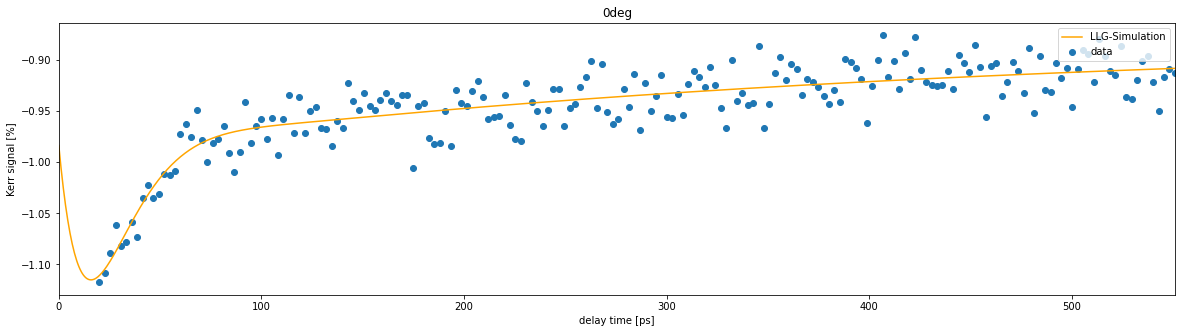

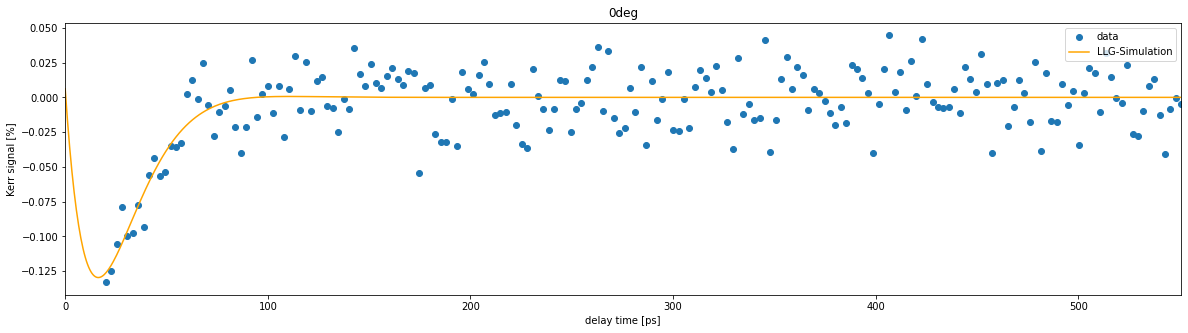

Data=A*exp(-t/τ)*sin(ω*t+θ)+B*exp(-t/τ0)+C
A:0.6356486962553635[%],-1/τ:-0.05624725940020682[1/ps],ω:0.03340033474740024[rad/ps],θ:-0.009598801271161223[rad],
B:-0.11134247205733065[%],-1/τ0:-0.002400091115986227[1/ps],C:-0.8784387292972028[%]


In [5]:
xfunc1=np.linspace(0,x1[x1.shape[0]-1],1000)
model_func1 = lambda A, k, Omega , delta , x : A * np.exp(k * x)*np.sin(Omega*x + delta)
def fit(p,x):
    return p[0] * np.exp(p[1] * x)*np.sin(p[2]*x+p[3])+p[4]* np.exp(p[5] * x)+p[6]
def fit_exp3(p, x, y):
    return y - fit(p,x)
fitting_parameter3=np.append([exp_A,exp_t,2*np.pi*exp_freq,0],fitting_func)
result=leastsq(fit_exp3, fitting_parameter3, args=(x1, y1))[0]
#上グラフ
fig5,ax5 = plt.subplots(figsize=[20,5])
ax5.plot(xfunc1,fit(result,xfunc1),label="LLG-Simulation",color="orange")
ax5.scatter(x1, y1, label="data")
ax5.set_xlabel("delay time [ps]")
ax5.set_ylabel("Kerr signal [%]")
ax5.set_xlim(0,x1[x1.shape[0]-1])
ax5.legend(loc = 'upper right')
ax5.set_title(tittle)
#下グラフ
fig6,ax6 = plt.subplots(figsize=[20,5])
ax6.scatter(x1, y1-middle_func(result[4],result[5],x1,result[6]), label="data")
ax6.plot(xfunc1,model_func1(result[0],result[1],result[2],result[3],xfunc1),label="LLG-Simulation",color="orange")
ax6.set_xlabel("delay time [ps]")
ax6.set_ylabel("Kerr signal [%]")
ax6.set_xlim(0,x1[x1.shape[0]-1])
ax6.legend(loc = 'upper right')
ax6.set_title(tittle)
plt.show()
print("Data=A*exp(-t/τ)*sin(ω*t+θ)+B*exp(-t/τ0)+C")
print("A:{}[%],-1/τ:{}[1/ps],ω:{}[rad/ps],θ:{}[rad],\nB:{}[%],-1/τ0:{}[1/ps],C:{}[%]".format(abs(result[0]),result[1],result[2],result[3],result[4],result[5],result[6]))

In [6]:
#fitting結果 保存用
#fig5.savefig("fitting-result.jpg",bbox_inches='tight',pad_inches=0.03)
#fig6.savefig("fitting-result2.jpg",bbox_inches='tight',pad_inches=0.03)